In [1]:
import pymongo
from pymongo import MongoClient
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from sklearn import preprocessing
import warnings
import sys
import os
def nbipath():
    os.chdir('..')
    path = os.getcwd()+'/nbi'
    return path 

sys.path.insert(0, nbipath())
from nbi1 import *

from numpy.random import randn
from scipy.stats import anderson
from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import scipy

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats


import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

warnings.filterwarnings('ignore')

In [2]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

def undersample(df, keyword):
    """
    It will take a dataframe and a keyword to groupby
    :input: df: Dataframe
            Key-word: column to groupby
            
    :return: undersample_df: Datafram
    
    """
    groupby_df = df.groupby([keyword]).count()
    count = min(groupby_df[groupby_df.columns[0]].tolist())
    
    tempdf_list = []

    for index in df[keyword].unique():
        tempdf_list.append(df[df[keyword] == index].sample(count)) ## Count
    
    undersample_df = pd.concat(tempdf_list)
    
    return undersample_df

def aov(df, formula):
    """
    :input: df: DataFrame
            formula: 
    
    :return: 
            Table
    """  
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)

    eta_squared(aov_table)
    return omega_squared(aov_table)
    
def createDictionary(dataframe_col1, dataframe_col2):
    """
    returns dictionary of structure number as key and and list of attribute belonging  to structure number
    :rtype: dictionary
    
    """
    # initialize the dictionary
    dictionary = {structure_number:[] for structure_number in snowfall_csv['structure_number']}
    
    for structure_number, value in zip(dataframe_col1, dataframe_col2):
        dictionary[structure_number].append(value)
    return dictionary


def createDictionaryOfMeanValue(dictionary):
    """
    returns dictionary of structure number as key and and mean values in corresponding to the structure number
    :rtype: dictionary
    
    """
    dictionary_new = {}
    
    for key, value in dictionary.items():
        mean_value = np.mean(value)
        dictionary_new[key] = mean_value
        
    return dictionary_new

def createDictionaryOfFirstValue(dictionary):
    dictionary_new = {}
    
    for key, value in dictionary.items():
        value = value[0]
        dictionary_new[key] = value
        
    return dictionary_new



### Importing data

In [3]:


snowfall_csv = pd.read_csv('/Users/AkshayKale/Documents/github/data/freezethaw-snowfall/freezethaw-snowfall-allstates-allyears.csv', index_col=0)
d_structureNumber_county = createDictionary(snowfall_csv['structure_number'],snowfall_csv['COUNTY_NAME'])
d_structureNumber_freeze_thaw = createDictionary(snowfall_csv['structure_number'],snowfall_csv['NO_OF_FREEZE_THAW_CYCLES'])
d_structureNumber_no_of_snowfall = createDictionary(snowfall_csv['structure_number'],snowfall_csv['no_of_snowfalls'])

In [5]:
snowfall_csv.head(10)

,state_code,structure_number,county_code,COUNTY_NAME,Year,NO_OF_FREEZE_THAW_CYCLES,no_of_snowfalls
1,27,000032540-00033,1.0,Aitkin County,1980.0,69.0,130.0
2,27,000032540-00033,1.0,Aitkin County,1981.0,89.0,108.0
3,27,000032540-00033,1.0,Aitkin County,1982.0,58.0,125.0
4,27,000032540-00033,1.0,Aitkin County,1983.0,76.0,130.0
5,27,000032540-00033,1.0,Aitkin County,1984.0,81.0,115.0
6,27,000032540-00033,1.0,Aitkin County,1985.0,85.0,124.0
7,27,000032540-00033,1.0,Aitkin County,1986.0,68.0,131.0
8,27,000032540-00033,1.0,Aitkin County,1987.0,96.0,88.0
9,27,000032540-00033,1.0,Aitkin County,1988.0,82.0,123.0
10,27,000032540-00033,1.0,Aitkin County,1989.0,70.0,133.0


### Creating dictionary of structure number as key and snowfall, county, and freeze thaw as value

In [6]:
d_snowfall = createDictionaryOfMeanValue(d_structureNumber_no_of_snowfall)

### Importing NBI records 

In [4]:
csv_file = "/Users/AkshayKale/Documents/github/data/nbi/06-20-19-thesis-dataset-without-outliers_allstates"
df_wo = pd.read_csv(csv_file, index_col = 0)

## Selecting bridges with no change in structure length over time

### Shape of the databframe

In [7]:
df_wo[df_wo['No Change structure length'] == True].shape

(292457, 30)

### Selecting bridges with no change in structure length

In [8]:
df_wo = df_wo[df_wo['No Change structure length'] == True]
df_wo = df_wo[~df_wo['Structure Length'].isin([-1,0, ])]
df_wo = df_wo[df_wo['Structure Length']>6]

### Removing null values

In [9]:
df_wo = df_wo[~df_wo['Structure Length'].isin([-1,0, ])]

### Selecting bridges only with the structure length greater than 6 

In [10]:
df_wo = df_wo[df_wo['Structure Length']>6]

### Select records from Nebraska

In [11]:
# select records only with state code 31 (Nebraska)
NE = df_wo[df_wo['State Code'] == 31]

# creating a new column for structure numbers
NE['SN'] = [structureNumber[:-2] for structureNumber in NE['Structure Number']]
NE['No. of Snow Fall'] = NE['SN'].map(d_snowfall)

# drop all rows with any null value
NE_clean = NE.dropna()

# categorizing snowfall into very low, medium, and hard
NE_clean['snowfall'] = pd.qcut(NE_clean['No. of Snow Fall'],[0, .05, .95, 1.], labels = ['Very Low','Medium','Very High'])

### Understanding the distirbution of the Mean Snowfall in the state of Nebraska with respect to bridges

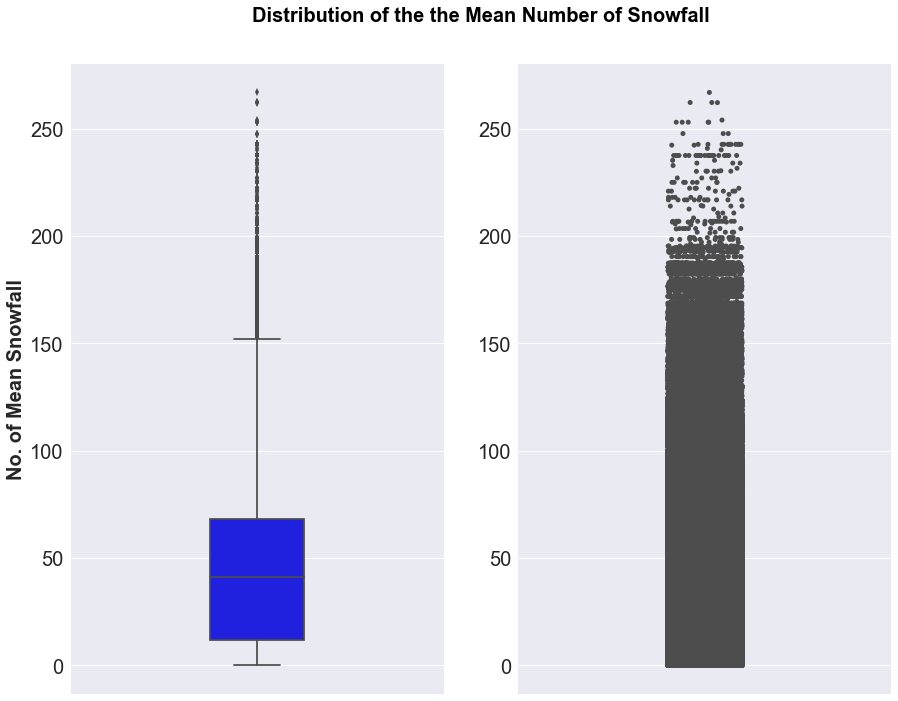

In [12]:
# creating a list of mean snowfall values
mean_snowfall = list(d_snowfall.values())

# Plotting distribution of the mean snowfall
plt.figure(figsize=(12,10))
plt.subplots_adjust(bottom=0.025, left=0.025, top = 0.9, right=0.975)
plt.suptitle("Distribution of the the Mean Number of Snowfall", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.subplot(1,2,1)
sns.boxplot(x = mean_snowfall,  color = 'blue', orient='v', width = 0.25)
plt.ylabel("No. of Mean Snowfall", fontsize = 20, fontweight = "bold")

plt.subplot(1,2,2)
sns.stripplot(y= mean_snowfall, jitter=True, color=".3")
plt.show()

### Five point summary of very low snowfall

#### Very High Number of Snowfall

In [13]:
pd.DataFrame(NE_clean[NE_clean['snowfall'] == 'Very High']['No. of Snow Fall'].describe())

,No. of Snow Fall
count,323.000000
mean,70.194313
std,0.702080
min,69.815789
25%,69.973684
50%,69.973684
75%,69.973684
max,73.315789


#### Very Low Number of Snowfall

In [14]:
pd.DataFrame(NE_clean[NE_clean['snowfall'] == 'Very Low']['No. of Snow Fall'].describe())

,No. of Snow Fall
count,478.000000
mean,44.852510
std,1.321333
min,41.973684
25%,44.026316
50%,45.473684
75%,45.947368
max,45.947368


## Statistical Analysis

In [15]:
# creating a dataframe
df_anova = NE_clean[['Baseline Difference Score', 'ADT Category','ADTT Category','Avg. Daily Precipitation', 'State Code',
                       'Material','Structure Type', 'Maintainer','snowfall']]

# renaming columns
df_anova = df_anova.rename(index=str, columns={"Baseline Difference Score": "score", \
                                               "ADT Category": "adt", \
                                               "ADTT Category": "adtt",\
                                               "Avg. Daily Precipitation": "precp", \
                                               "State Code":"region", \
                                               "Material":"material",\
                                               "Structure Type":"structuretype",\
                                               "Maintainer":"maintainer",\
                                               'snowfall':'snowfall'
                                              })

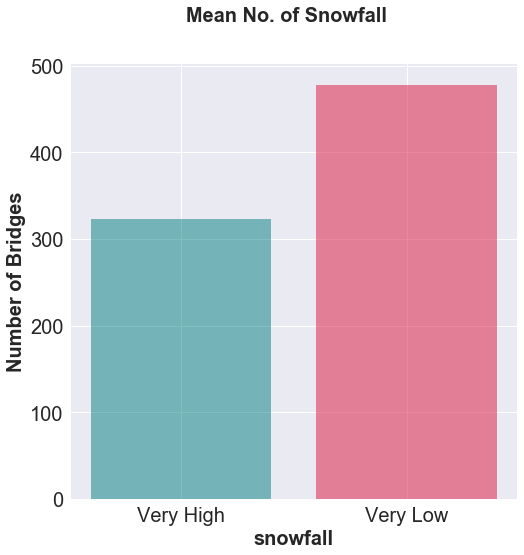

In [16]:
# count of bridges in each category of snowfall
count_snowfall = df_anova.groupby('snowfall')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Mean No. of Snowfall", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

#Subplot 1
labels = ["Very Low", "Very High"]
no_of_records = [count_snowfall[0], count_snowfall[2]]
plt.bar(labels, no_of_records, align = 'center', alpha = 0.5, color = ['crimson','teal'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.xlabel("snowfall", fontweight = 'bold', fontsize = 20)
plt.ylabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

### Distribution of bridges with very high snowfall and very low snowfall

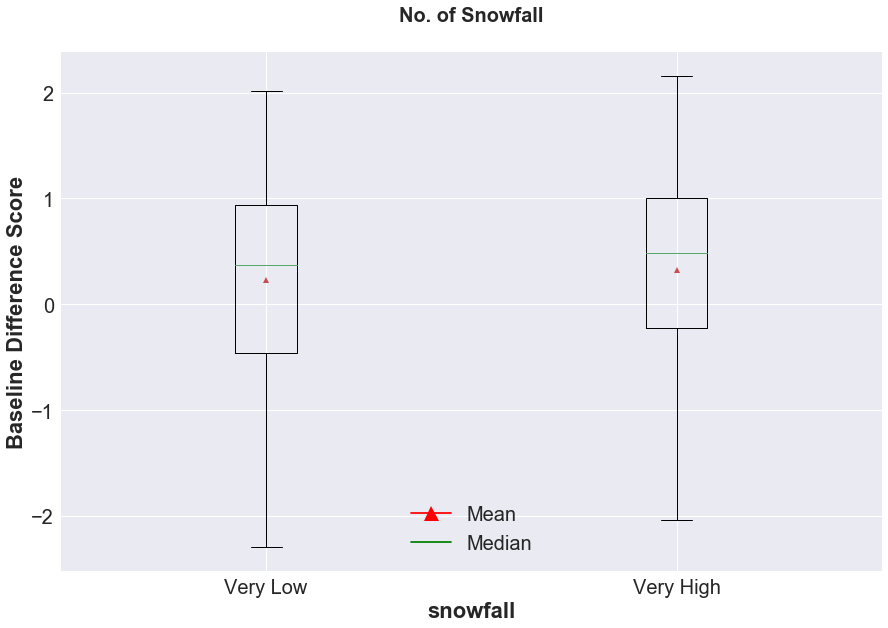

In [17]:
# creating a list of scores
scores_low = df_anova[df_anova['snowfall'] == 'Very Low']['score']
scores_high = df_anova[df_anova['snowfall'] == 'Very High']['score']
scores_snowfall = [scores_low,scores_high]


green_line = mlines.Line2D([], [], color='Green',
                          markersize=15, label='Median')
red_triangle = mlines.Line2D([], [], color='Red', marker='^',
                          markersize=15, label='Mean')

# Plotting 
plt.figure(figsize=(12,8))
plt.subplots_adjust(bottom=0, left=0.025, top = 0.9, right=0.975)
plt.suptitle("No. of Snowfall", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)

plt.boxplot(scores_snowfall, labels = labels, showfliers=True, showmeans=True)
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.xlabel("snowfall", fontweight = 'bold')
plt.ylabel("Baseline Difference Score", fontweight = 'bold')

red_patch = mpatches.Patch(color='red', label='The red data')
green_patch = mpatches.Patch(color='green', label='The red data')
plt.legend(handles=[red_triangle, green_line], loc = 'lower center')

plt.show()

### Adding new column for material name

In [18]:
df_anova['materialname'] = retMaterialNames(df_anova['material'])
df_anova = df_anova[df_anova['materialname'].isin(['Concrete', 'Prestressed Concrete','Wood or Timber', 'Steel'])]

#### ANOVA - Small Sample

In [19]:
#span = df_anova.groupby('snowfall').apply(lambda s: s.sample(100))['snowfall'].tolist()
span_list_small = df_anova.groupby('snowfall').apply(lambda s: s.sample(100))
span = span_list_small['snowfall'].tolist()

score = df_anova.groupby('snowfall').apply(lambda s: s.sample(100))['score'].tolist()
df_span_sample_100 = pd.DataFrame({'snowfall':span, 'score':score})
df_span_100 = df_span_sample_100[df_span_sample_100['snowfall'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(snowfall)'
span_undersample = undersample(df_span_100, 'snowfall')
aov(span_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(snowfall),2.455707,1.0,3.088307,0.080402,0.015358,0.010334
Residual,157.442239,198.0,NaN,NaN,NaN,NaN


#### ANOVA - Two way 

In [20]:
#span = df_anova.groupby('snowfall').apply(lambda s: s.sample(100))['snowfall'].tolist()

span_list_small = df_anova.groupby('snowfall').apply(lambda s: s.sample(100))
span = span_list_small['snowfall'].tolist()
material= span_list_small['material'].tolist()

score = df_anova.groupby('snowfall').apply(lambda s: s.sample(100))['score'].tolist()
df_span_sample_100 = pd.DataFrame({'snowfall':span, 'score':score, 'material':material})
df_span_100 = df_span_sample_100[df_span_sample_100['snowfall'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(snowfall) + C(material) + C(snowfall):C(material)'
span_undersample = undersample(df_span_100, 'snowfall')
aov(span_undersample, formula)


,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(snowfall),2.537693,1.0,3.256414,0.072712,0.016386,0.011297
C(material),1.870004,3.0,0.799874,0.495323,0.012075,-0.003006
C(snowfall):C(material),0.837247,3.0,0.358124,0.783316,0.005406,-0.009641
Residual,149.623780,192.0,NaN,NaN,NaN,NaN


### Cohen's d: 0.61

#### ANOVA - Large Sample

In [21]:
samplesize = min(df_anova.groupby(['snowfall'])['snowfall'].count())
#span = df_anova.groupby('snowfall').apply(lambda s: s.sample(samplesize))['snowfall'].tolist()

span_list = df_anova.groupby('snowfall').apply(lambda s: s.sample(samplesize))
span = span_list['snowfall'].tolist()
score = df_anova.groupby('snowfall').apply(lambda s: s.sample(samplesize))['score'].tolist()
df_span_sample_45121 = pd.DataFrame({'snowfall':span, 'score':score})
df_span_45121 = df_span_sample_45121[df_span_sample_45121['snowfall'].isin(['Very Low', 'Very High'])]

formula = 'score ~ C(snowfall)'
span_undersample = undersample(df_span_45121, 'snowfall')
aov(span_undersample, formula)

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(snowfall),3.731568,1.0,4.174998,0.041522,0.007875,0.005977
Residual,470.133102,526.0,NaN,NaN,NaN,NaN


### Cohen's d: 0.62

## Further analysis

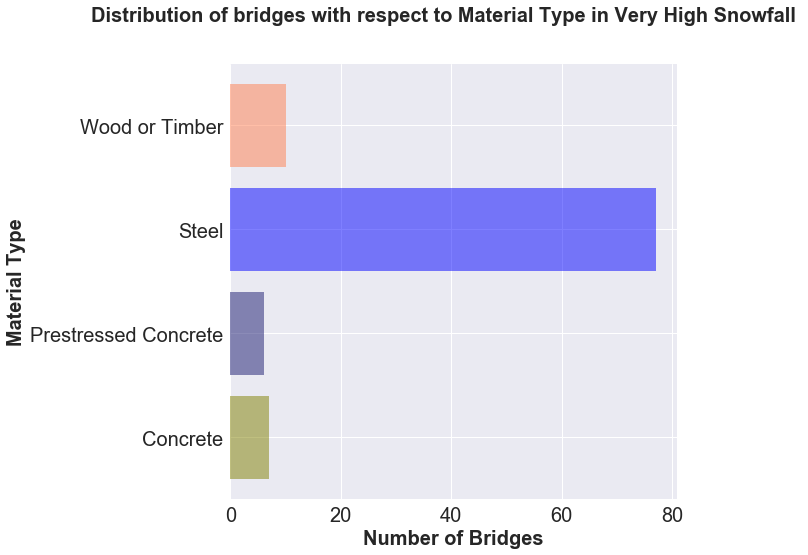

In [22]:
#scores_high = df_anova[df_anova['snowfall'] == 'Very High']
scores_high = span_list_small[span_list_small['snowfall'] == 'Very High']
scores_high['materialname'] = retMaterialNames(scores_high['material'])

#low_mat = scores_high[scores_high['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]
low_mat = scores_high[scores_high['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]
count_mat = low_mat.groupby('materialname')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Distribution of bridges with respect to Material Type in Very High Snowfall ", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)


labels = ["Concrete", "Prestressed Concrete",\
          "Steel", "Wood or Timber"]

no_of_records = count_mat
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['olive','midnightblue','blue','coral'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Material Type", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()

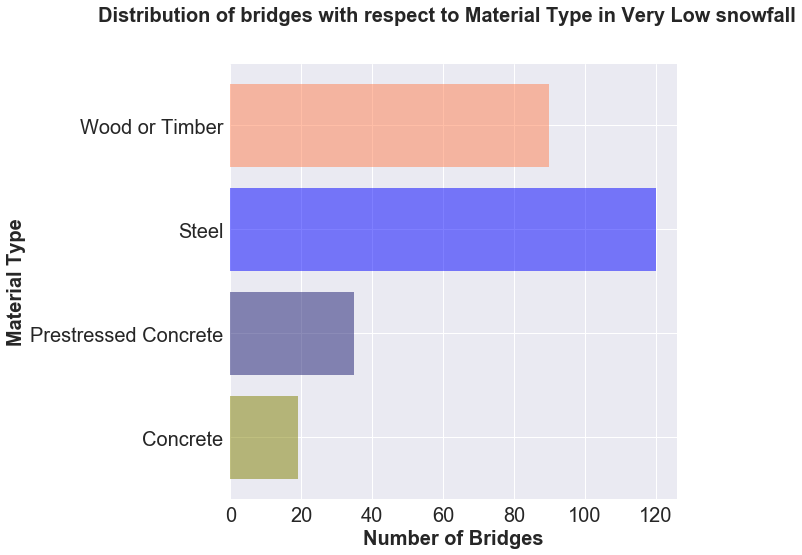

In [23]:
scores_low = span_list[span_list['snowfall'] == 'Very Low']
scores_low['materialname'] = retMaterialNames(scores_low['material'])
low_mat = scores_low[scores_low['materialname'].isin(["Wood or Timber","Concrete", "Steel","Prestressed Concrete"])]
count_mat = low_mat.groupby('materialname')['score'].count()

# Plotting 
plt.figure(figsize=(8,8))
plt.suptitle("Distribution of bridges with respect to Material Type in Very Low snowfall", fontsize = 20, fontweight = 'bold')
sns.set(font_scale=2)


labels = ["Concrete", "Prestressed Concrete",\
          "Steel", "Wood or Timber"]

no_of_records = count_mat
plt.barh(labels, no_of_records, align = 'center', alpha = 0.5, color = ['olive','midnightblue','blue','coral'])
plt.xticks(size = 20, rotation = 0)
plt.yticks(size = 20)
plt.ylabel("Material Type", fontweight = 'bold', fontsize = 20)
plt.xlabel("Number of Bridges", fontweight = 'bold', fontsize = 20)
plt.show()